In [128]:
#%pip install torch torchvision
#%pip install opencv-contrib-python
#%pip install scikit-learn
#%pip install matplotlib
#%pip install pandas
#%pip install numpy
#%pip install tqdm

In [129]:
# OUR SOURCE : https://blog.paperspace.com/object-localization-pytorch-2/
# Python 3-9

import copy
import random
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.datasets import KMNIST
from torch.optim import Adam
import torch.nn.functional as F
from torch import nn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import argparse
import torch
import time
import PIL
from torch import optim
import os
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten
from torch import optim
import tqdm


In [130]:
train, test = train_test_split(pd.read_csv("../../annotation_dataset_formated.csv"),test_size=0.2)
img_dir = "../../dataset/"
print(test)

     filename  ax1  ay1  bx2  by2
40    40.jpeg  141  199  180  188
80    80.jpeg  161  199  131  173
8      8.jpeg   55  199   43  188
76    76.jpeg  141  199  146  180
94    94.jpeg  155  199  150  189
24    24.jpeg   84  198  116  171
48    48.jpeg    3  195   54  175
16    16.jpeg  116  198  134  179
45    45.jpeg  110  199  115  188
2      2.jpeg  130  199  180  177
100  100.jpeg  113  199   72  174
53    53.jpeg   89  200   65  183
59    59.jpeg  138  200  115  156
88    88.jpeg  134  198  155  176
113  113.jpeg  134  199  123  185
50    50.jpeg  141  200  144  180
109  109.jpeg   90  198   81  179
91    91.jpeg   62  198   47  174
57    57.jpeg  133  199  130  179
42    42.jpeg  159  198  159  179
39    39.jpeg  132  200  158  171
78    78.jpeg  148  198  148  162
95    95.jpeg  131  199  143  182


In [131]:
import cv2
def open_images(paths):
        images = []
        for path in paths:
                with PIL.Image.open(img_dir + path) as image:
                        images.append(np.asarray(image))
                
        return np.array(images)

def preprocess_images(images):
        processed_images = []
        for image in images:
                processed_image = cv2.Canny(image,55,200)

                # put a opacity of the original image back in
                processed_image = np.where(processed_image == 0, image, processed_image)
                processed_image[:150] = 0
                
                processed_images.append(np.expand_dims(processed_image, axis= 2))
                
        return np.array(processed_images)

In [132]:
import cv2
#make edges detection on images

train_img = open_images(train["filename"])
test_img = open_images(test["filename"])
train_img = preprocess_images(train_img)
test_img = preprocess_images(test_img)
train_img.shape

(91, 200, 200, 1)

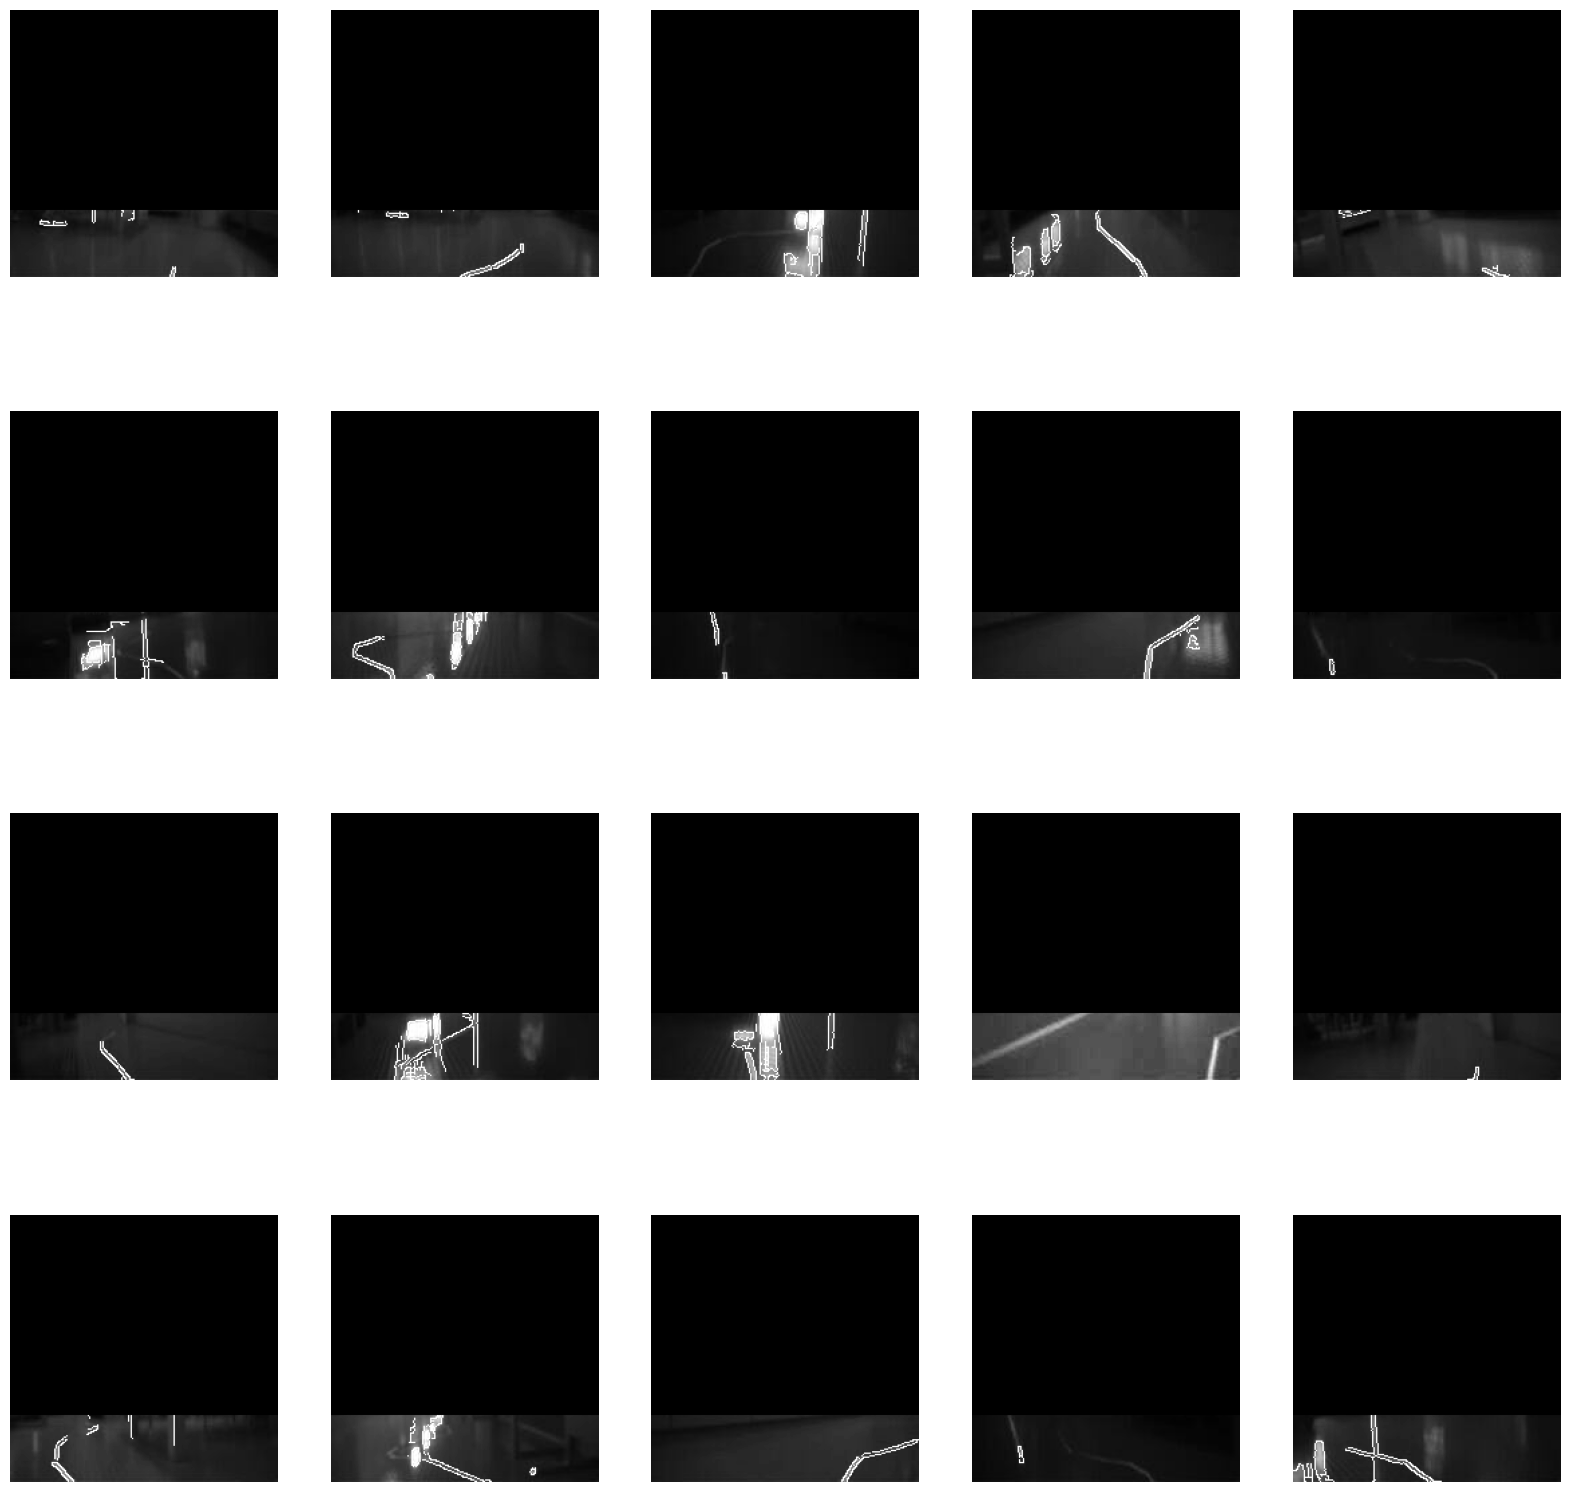

In [133]:
# Create a Matplotlib figure
plt.figure(figsize=(20,20))

# Generate a random sample of images each time the cell is run 
random_range = random.sample(range(1, len(train_img)), 20)

for itr, i in enumerate(random_range, 1):



    image = train_img[i]


# Clip the values to 0-1 and draw the sample of images
    
    plt.subplot(4, 5, itr)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
plt.show()


In [134]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cpu')

In [135]:
class Dataset():
    def __init__(self, train_images, train_coords):
        self.images = torch.from_numpy(train_images).float()
        self.coords = torch.from_numpy(train_coords).float()

    def __len__(self):
        return len(self.coords)

    # To return x,y values in each iteration over dataloader as batches.

    def __getitem__(self, idx):
        return (self.images[idx],
              self.coords[idx])

train_coords = train.loc[:,('ax1','ay1','bx2','by2')].values
test_coords = test.loc[:,('ax1','ay1','bx2','by2')].values

dataset_train = Dataset(np.transpose(train_img,(0,3,1,2)),train_coords)
dataset_test = Dataset(np.transpose(test_img,(0,3,1,2)),test_coords)

print(dataset_train[0][0].shape)

torch.Size([1, 200, 200])


In [136]:
# OUR MODEL 
class CNN(Module):
    def __init__(self):
          # call the parent constructor
        super(CNN, self).__init__()

        # initialize first set of CONV => RELU => POOL layers
        self.conv1 = Conv2d(in_channels=1, out_channels=20,
            kernel_size=(5, 5))
        self.relu1 = ReLU()
        self.maxpool1 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        # initialize second set of CONV => RELU => POOL layers
        self.conv2 = Conv2d(in_channels=20, out_channels=50,
            kernel_size=(5, 5))
        self.relu2 = ReLU()
        self.maxpool2 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        # initialize first (and only) set of FC => RELU layers
        self.fc1 = Linear(in_features=50*47*47, out_features=500)
        self.relu3 = ReLU()
        # initialize our softmax classifier
        self.fc2 = Linear(in_features=500, out_features=4)


    def forward(self, x):
        # pass the input through our first set of CONV => RELU =>
        # POOL layers
        # normalize pixel value
        x /= 256.
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        # pass the output from the previous layer through the second
        # set of CONV => RELU => POOL layers
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        # flatten the output from the previous layer and pass it
        # through our only set of FC => RELU layers
        x = torch.flatten(x,start_dim=-3)     # flatten the tensor
        x = self.fc1(x)
        x = self.relu3(x)
        # pass the output to get our output
        # predictions
        output = F.sigmoid(self.fc2(x))
        return output 
model = CNN()
model = model.to(device)
model

CNN(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=110450, out_features=500, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=500, out_features=4, bias=True)
)

In [137]:
import math
n_epochs = 10 # number of epochs to run
batch_size = 8  # size of each batch
lr = 0.00002       # learning rate

# Line slope given two points:
def slope(x): 
    result = []
    for i in x :
        (x1, y1, x2, y2) = i
        result.append(math.atan((y2-y1)/(x2-x1)))
    return torch.from_numpy(np.array(result)).float()

dataloader = torch.utils.data.DataLoader(dataset_train, batch_size, shuffle=True)
valdataloader = torch.utils.data.DataLoader(dataset_test, batch_size, shuffle=True)

def train_model(model, dataloader, valdataloader, epochs, lr):

    optimizer = Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    history = []
    best_mse = 1000
    best_model = None
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        
        for i, (images, coords) in enumerate(dataloader):
            images = images.to(device)
            coords /= 200
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, coords)
            loss_angle = criterion(slope(outputs.detach().numpy()),slope(coords.detach().numpy() ))
            (loss + loss_angle).backward()
            optimizer.step()
            epoch_loss += loss.item()
        epoch_loss /= len(dataloader)
        history.append(epoch_loss)
        
        if epoch % 10 == 0:
            print("Epoch: %d, Loss: %1.5f" % (epoch, epoch_loss))

        if epoch_loss < best_mse:
            best_mse = epoch_loss
            best_model = copy.deepcopy(model)
    return best_model, history, best_mse

best_model, history, best_mse = train_model(model, dataloader, valdataloader, n_epochs, lr)

print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

/tmp/ipykernel_194092/2302661481.py:11: RuntimeWarning: divide by zero encountered in float_scalars
  result.append(math.atan((y2-y1)/(x2-x1)))


Epoch: 0, Loss: 0.03727


In [ ]:
def predict(model, image):
    model.eval()
    predictions = []
    with torch.no_grad():
            img = torch.from_numpy(np.transpose(image,(2,0,1))).float()
            img = img.to(device)
            output = model(img)
            
    return output.numpy() * 200





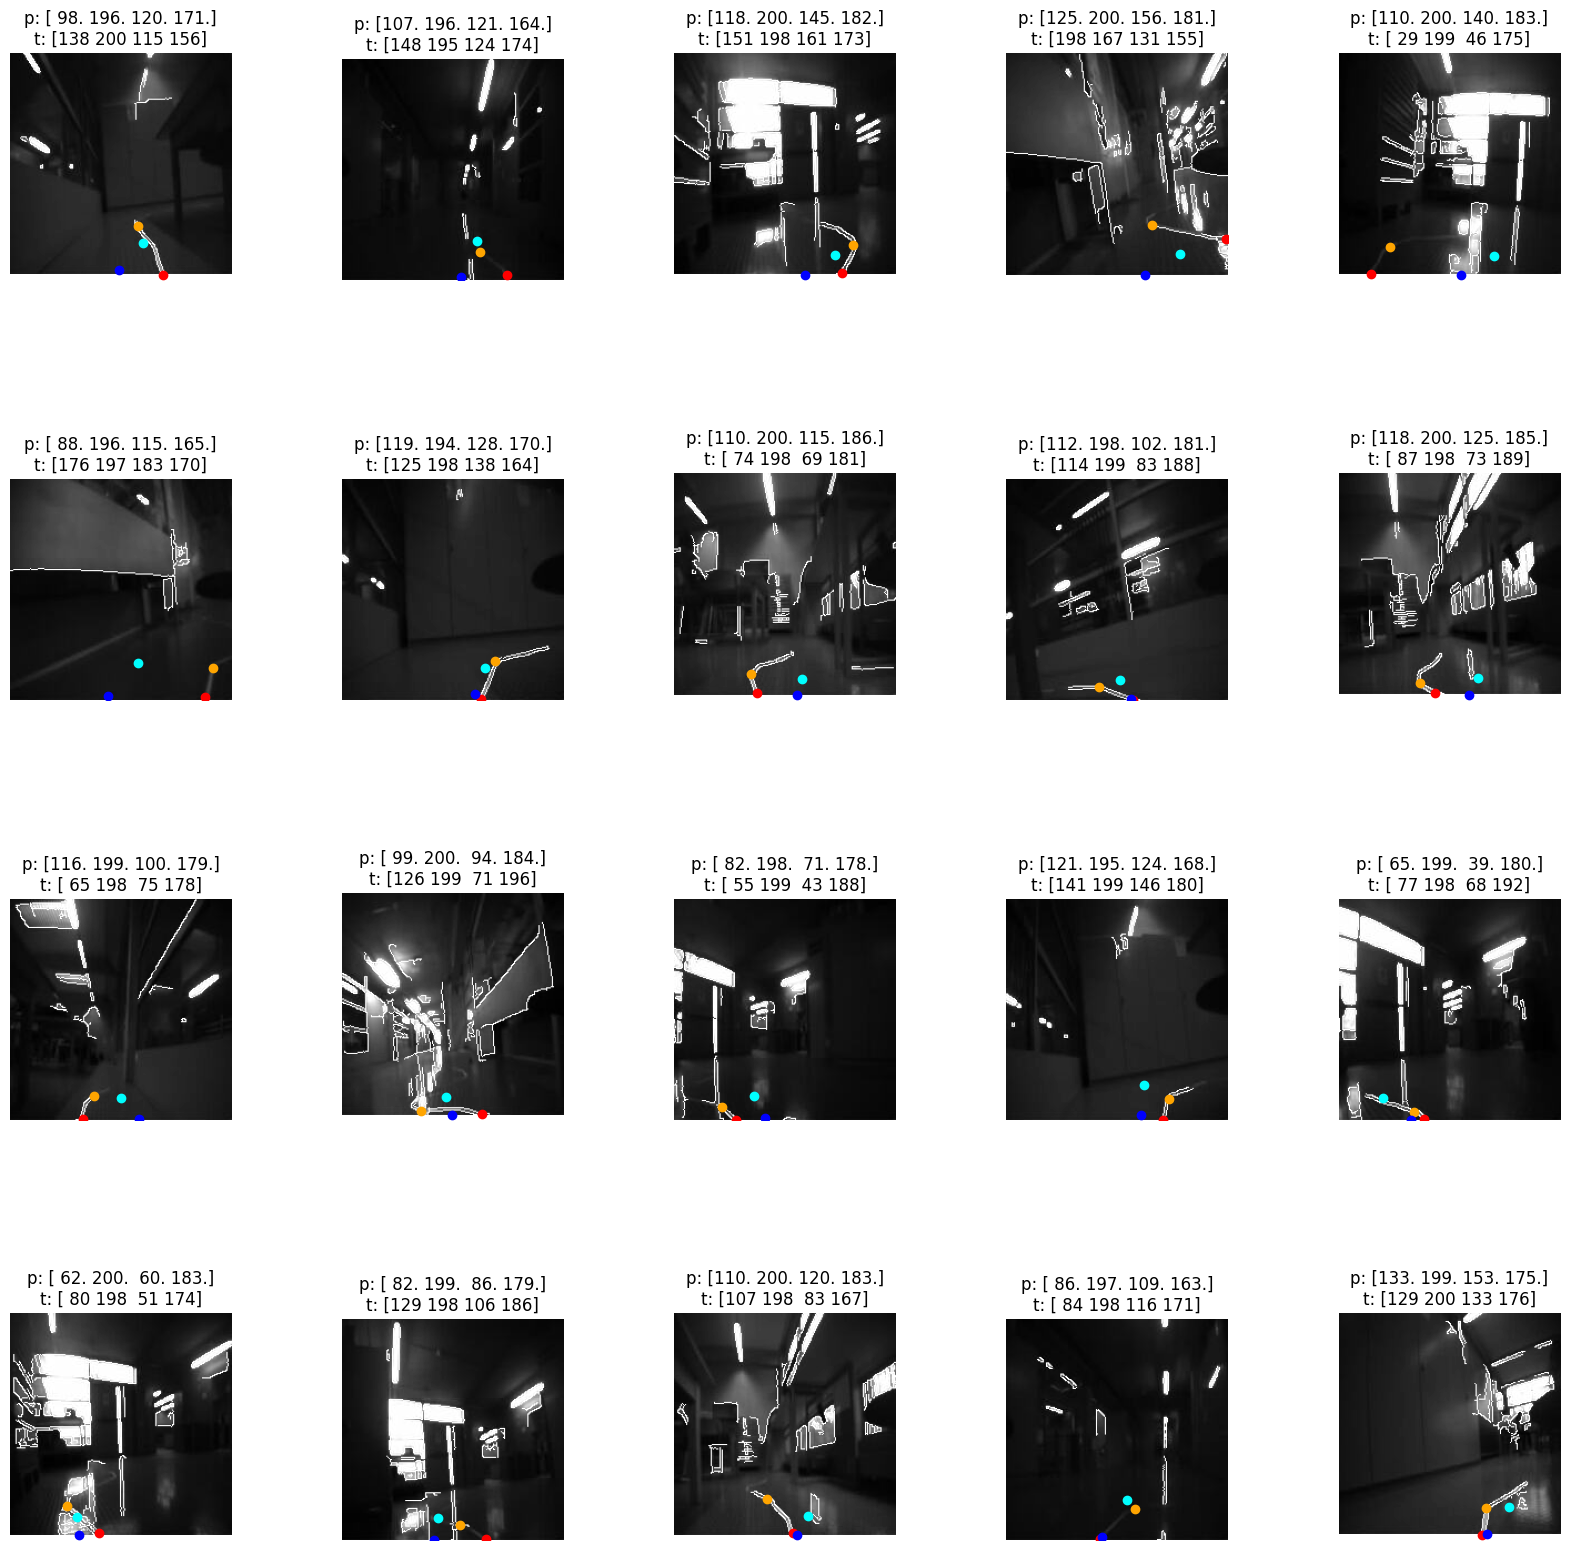

In [ ]:
# Generate a random sample of images each time the cell is run
random_range = random.sample(range(1, len(test_img)), 20)

plt.figure(figsize=(20,20))

for itr, i in enumerate(random_range, 1):
    img  = test_img[i]
    coords = test_coords[i]
    output = predict(model, img)

    # Clip the values to 0-1 and draw the sample of images
    plt.subplot(4, 5, itr)
    plt.imshow(test_img[i], cmap='gray')
    plt.axis('off')
    plt.title("p: " + str(np.round(output)) + "\nt: " + str(coords))

    # Plot the ground truth points with red variation
    plt.scatter(coords[0], coords[1], c='red', marker='o', label='Ground Truth A')
    plt.scatter(coords[2], coords[3], c='orange', marker='o', label='Ground Truth B')

    # Plot the prediction points with blue variation
    plt.scatter(output[0], output[1], c='blue', marker='o', label='Prediction A')
    plt.scatter(output[2], output[3], c='cyan', marker='o', label='Prediction B')

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=.5, wspace=0.5)

# Show the plot
plt.show()


In [ ]:
torch.save(model.state_dict(), "Big_Chad_Cnn.pt")